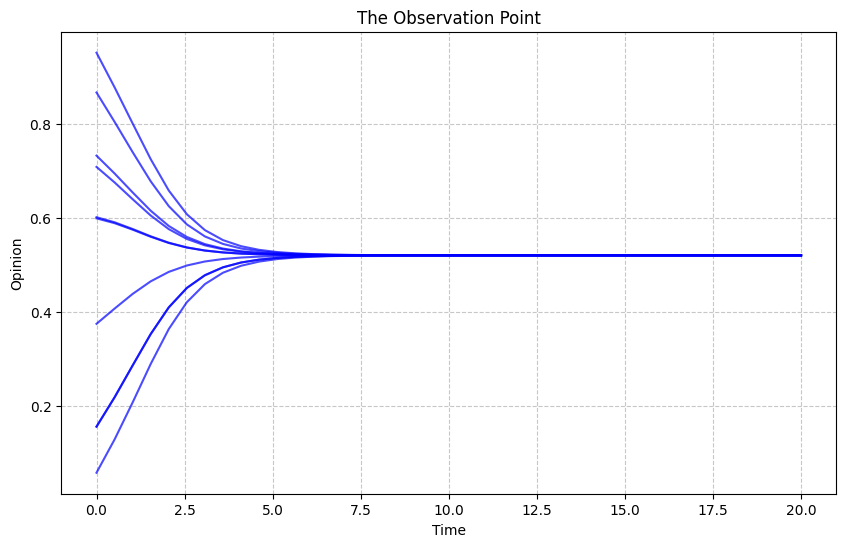

C:\Users\25291\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training:   0%|                                                                                | 0/200 [00:00<?, ?it/s]C:\Users\25291\AppData\Local\Temp\ipykernel_17624\3436993714.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision to avoid numerical instability
Training:   0%|                                                      | 0/200 [00:02<?, ?it/s, loss=0.0005, lr=0.001000]

Epoch 0, Loss: 0.000494


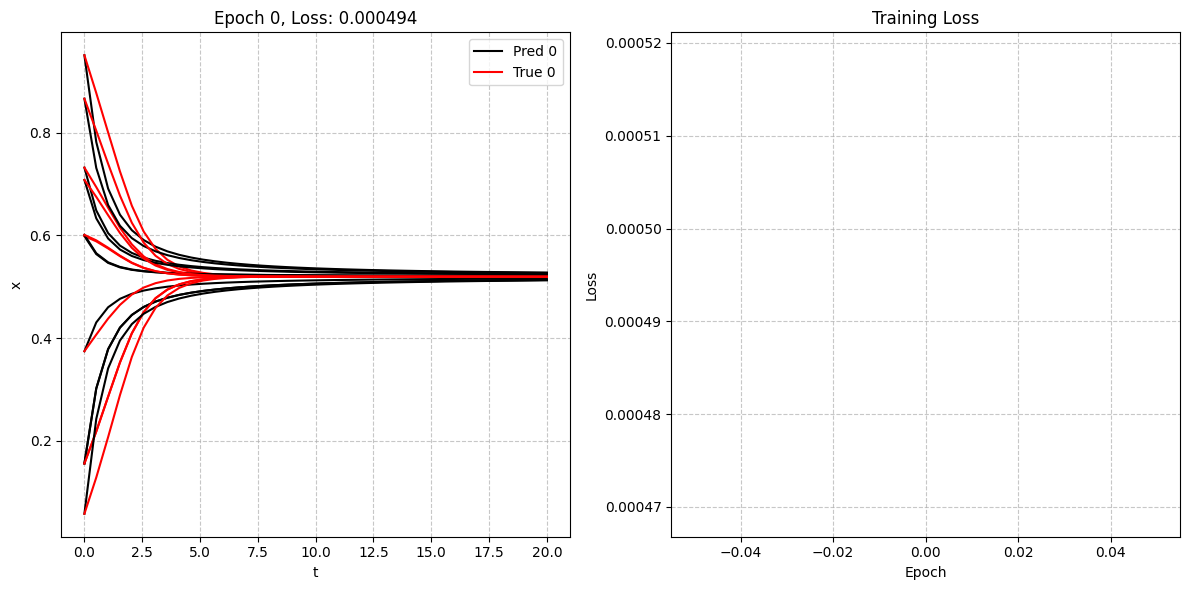

Training:   2%|▉                                             | 4/200 [00:09<07:43,  2.37s/it, loss=0.0003, lr=0.001000]


KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
from torchdiffeq import odeint
from tqdm import tqdm

"""
The version of the python(python 3.13) package:
    numpy == 2.1.2
    scipy == 1.15.1
    matplotlib == 3.9.2
    torch == 2.6.0
    torchdiffeq == 0.2.5
    tqdm == 4.67.1
"""

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


# Define the interaction kernel function phi(r)
def phi(r):
    return (1 + r ** 2) ** (-4)


# Define the ODE system: dX/dt = f(X, t)
def opinion_dynamics(t, X, N):
    dXdt = np.zeros_like(X)
    for i in range(N):
        dx = X - X[i]  # Opinion differences between all agents and agent i
        r = np.abs(dx)  # Absolute distances
        interaction = phi(r) * dx  # Interaction term: phi(r) * (x_j - x_i)
        velocity = np.mean(interaction, axis=0)  # Average interaction as velocity
        dXdt[i] = velocity
    return dXdt


# System parameters
N = 10  # Number of agents
d = 1  # Opinion dimension
T = 20  # Total time
L = 40  # Increase time points for higher sampling density
t_span = [0, T]
t_eval = np.linspace(t_span[0], t_span[1], L)

# Generate more uniform initial conditions to avoid extreme values
X0 = np.random.uniform(0, 1, N)

# Solve the ODE with more stable solver settings
sol = solve_ivp(
    lambda t, X: opinion_dynamics(t, X, N),
    t_span,
    X0,
    t_eval=t_eval,
    method='RK45',  # Use adaptive step-size RK45 method
    rtol=1e-6,
    atol=1e-9,
    dense_output=True  # Enable dense output for more accurate solution
)

# Visualize the original data
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(t_eval, sol.y[i], color='blue', alpha=0.7)  # Trajectories of each agent
plt.xlabel('Time')
plt.ylabel('Opinion')
plt.title('The Observation Point')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Extract simulated data as training data
true_trajectory = sol.y.T  # (L, N)
t_eval_tensor = torch.tensor(t_eval, dtype=torch.float32)
true_data = torch.tensor(true_trajectory, dtype=torch.float32)


# Define a more stable neural network architecture
class PhiNN(nn.Module):
    """ Neural network approximating φ(r) """

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),  # Increase network width for better expressiveness
            nn.Tanh(),  # Use Tanh instead of ReLU to avoid vanishing gradients
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

        # Initialize network weights
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                nn.init.zeros_(m.bias)

    def forward(self, r):
        # Add small regularization to input to avoid numerical issues at r=0
        r = torch.clamp(r, min=1e-8)
        return self.net(r.unsqueeze(-1)).squeeze() + 1e-8  # Ensure non-zero output


class NeuralODE(nn.Module):
    def __init__(self, N, phi_nn):
        super().__init__()
        self.N = N
        self.phi_nn = phi_nn

    def forward(self, t, X):
        dXdt = torch.zeros_like(X)
        for i in range(self.N):
            dx = X - X[i]  # Opinion differences
            r = torch.abs(dx)  # Absolute distances
            interaction = self.phi_nn(r) * dx
            dXdt[i] = torch.mean(interaction, dim=0)  # Explicitly specify dimension
        return dXdt


# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
phi_nn = PhiNN().to(device)
model = NeuralODE(N, phi_nn).to(device)

# Use learning rate scheduler
optimizer = optim.Adam(phi_nn.parameters(), lr=1e-3, eps=1e-8)  # Increase eps to prevent division by zero
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
    verbose=True,
    min_lr=1e-6
)

criterion = nn.MSELoss()

# Move data to device
true_data = true_data.to(device)
t_eval_tensor = t_eval_tensor.to(device)

# Gradient clipping setup
max_grad_norm = 1.0  # Gradient clipping threshold

# Training loop
epochs = 200
pbar = tqdm(range(epochs), desc="Training")
loss_history = []

for epoch in pbar:
    optimizer.zero_grad()

    try:
        # Forward pass (solve ODE)
        with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision to avoid numerical instability
            pred_data = odeint(
                model,
                true_data[0],
                t_eval_tensor,
                method='dopri5',
                rtol=1e-5,
                atol=1e-7
            )

        # Compute loss
        loss = criterion(pred_data, true_data)

        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch}!")
            # Optionally save current model state for debugging
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 'nan_checkpoint.pth')
            break

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent gradient explosion
        nn.utils.clip_grad_norm_(phi_nn.parameters(), max_grad_norm)

        # Update parameters
        optimizer.step()

        # Update learning rate
        scheduler.step(loss)

        # Record loss
        loss_history.append(loss.item())
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{optimizer.param_groups[0]['lr']:.6f}")

        # Visualize training progress
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            for i in range(N):
                plt.plot(t_eval_tensor.cpu().numpy(), pred_data[:, i].cpu().detach().numpy(), 'k-',
                         label=f'Pred {i}' if i == 0 else None)
                plt.plot(t_eval_tensor.cpu().numpy(), true_data[:, i].cpu().numpy(), 'r-',
                         label=f'True {i}' if i == 0 else None)
            plt.xlabel('t')
            plt.ylabel('x')
            plt.legend()
            plt.title(f'Epoch {epoch}, Loss: {loss.item():.6f}')
            plt.grid(True, linestyle='--', alpha=0.7)

            plt.subplot(1, 2, 2)
            plt.plot(loss_history)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

    except RuntimeError as e:
        print(f"Error at epoch {epoch}: {e}")
        # Optionally save current model state for debugging
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'error_checkpoint.pth')
        break

# Visualize final results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(N):
    plt.plot(t_eval_tensor.cpu().numpy(), pred_data[:, i].cpu().detach().numpy(), 'k--',
             label=f'Pred {i}' if i == 0 else None)
    plt.plot(t_eval_tensor.cpu().numpy(), true_data[:, i].cpu().numpy(), 'r-', label=f'True {i}' if i == 0 else None)
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.title('Final Prediction vs True Trajectory')
plt.grid(True, linestyle='--', alpha=0.7)

# Compare learned φ(r) with true φ(r)
plt.subplot(1, 2, 2)
r_values = torch.linspace(0, 2, 100).to(device)
true_phi = phi(r_values.cpu().numpy())
with torch.no_grad():
    pred_phi = phi_nn(r_values).cpu().numpy()
plt.plot(r_values.cpu().numpy(), true_phi, 'r-', label='True φ(r)')
plt.plot(r_values.cpu().numpy(), pred_phi, 'k--', label='Learned φ(r)')
plt.xlabel('r')
plt.ylabel('φ(r)')
plt.legend()
plt.title('True vs Learned Interaction Kernel')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()